In [21]:
import argparse
import sys
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
import cv2
import os

from model import ViT
from vit_rollout import VITAttentionRollout
# from vit_grad_rollout import VITAttentionGradRollout

In [22]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use_cuda', action='store_true', default=True,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument('--image_path', type=str, default='./examples/both.png',
                        help='Input image path')
    parser.add_argument('--head_fusion', type=str, default='max',
                        help='How to fuse the attention heads for attention rollout. \
                        Can be mean/max/min')
    parser.add_argument('--discard_ratio', type=float, default=0.9,
                        help='How many of the lowest 14x14 attention paths should we discard')
    parser.add_argument('--category_index', type=int, default=None,
                        help='The category index for gradient rollout')
    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print("Using GPU")
    else:
        print("Using CPU")

    return args

In [23]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    print("img ", img.shape)
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = heatmap.transpose(2, 0, 1)

    print("hm ", heatmap.shape)
    heatmap = np.float32(heatmap) / 255
    print("hm ", heatmap.shape)
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [24]:
# args = get_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) 

cuda


In [25]:
model = ViT(
    image_size=64,
    patch_size=4,
    output_size=64,
    dim=1024,
    depth=4,
    heads=16,
    mlp_dim=2048,
    channels=2,
    dropout=0.1,
    emb_dropout=0.1
).to(device)




checkpoint_path = f'checkpoint/model_epoch_60.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(torch.load("checkpoint/model_epoch_60.pt"))

model.eval()



ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=32, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
      

In [26]:
for name, module in model.named_modules():
            print(name)


to_patch_embedding
to_patch_embedding.0
to_patch_embedding.1
to_patch_embedding.2
to_patch_embedding.3
dropout
transformer
transformer.norm
transformer.layers
transformer.layers.0
transformer.layers.0.0
transformer.layers.0.0.norm
transformer.layers.0.0.attend
transformer.layers.0.0.attn_dropout
transformer.layers.0.0.to_qkv
transformer.layers.0.0.to_out
transformer.layers.0.0.to_out.0
transformer.layers.0.0.to_out.1
transformer.layers.0.1
transformer.layers.0.1.net
transformer.layers.0.1.net.0
transformer.layers.0.1.net.1
transformer.layers.0.1.net.2
transformer.layers.0.1.net.3
transformer.layers.0.1.net.4
transformer.layers.0.1.net.5
transformer.layers.1
transformer.layers.1.0
transformer.layers.1.0.norm
transformer.layers.1.0.attend
transformer.layers.1.0.attn_dropout
transformer.layers.1.0.to_qkv
transformer.layers.1.0.to_out
transformer.layers.1.0.to_out.0
transformer.layers.1.0.to_out.1
transformer.layers.1.1
transformer.layers.1.1.net
transformer.layers.1.1.net.0
transformer.l

In [27]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [28]:
true_dir = 'data/true'
pred_dir = 'data/pred'
os.makedirs(true_dir, exist_ok=True)
os.makedirs(pred_dir, exist_ok=True)
y_pred = np.load('y_pred.npy')#.to(device)
y_true = np.load('y_true.npy')#.to(device)

In [29]:
def vorticity(v): #-> 64x64x2 
    v = np.transpose(v, axes=(2,0,1))
    partials = tuple(np.gradient(i) for i in v)
    jacobian = np.stack(partials).reshape(*(j := (2,) * 2), *(64,64))
    # Extract divergence and curl from jacobian.
    divergence = np.trace(jacobian)
    curl_mask = np.triu(np.ones(j, dtype=bool), k=1)
    curl = (jacobian[curl_mask] - jacobian[curl_mask.T]).squeeze()
    return curl

In [39]:
import matplotlib.pyplot as plt

for i in range(2):
    
    input_tensor1 = torch.tensor(y_true[i]).to(device)
    print("it1",input_tensor.shape)
    input_tensor = input_tensor1.unsqueeze(0)
    # model(input_tensor)
    print(input_tensor.shape)

    # if args.category_index is None:
    print("Doing Attention Rollout")
    head_fusion = 'max'
    discard_ratio = 0.9
    attention_rollout = VITAttentionRollout(model,  head_fusion='max', 
        discard_ratio=0.9)
    with torch.no_grad():
        model(input_tensor)
    attentions = attention_rollout.attentions
    print("attn", np.array(attentions).shape)
    attentions = [(torch.eye(att.size(-1)) + att)/(torch.eye(att.size(-1)) + att).sum(dim=-1).unsqueeze(-1) for att in attentions]

    print("attn", np.array(attentions).shape)

    result = torch.max(attentions[0], dim=1)[0]
    # Max or mean both are fine
    for i in range(1, 4):
        att = torch.max(attentions[i], dim=1)[0]
        result = torch.matmul(att, result)

    masks = result
    print("mask1 ",masks.shape)
    masks = masks[:, 0, 1:]
    print("mask1 ",masks.shape)

    # img = y_true[i].unsqueeze(0)

    # img = y_true[i]
    # # img = y_true[i].unsqueeze(0)
    # mask = attention_rollout(input_tensor)
    # print(mask.shape)
    # # # name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, args.head_fusion)
    # # # else:
    # # #     print("Doing Gradient Attention Rollout")
    # # #     grad_rollout = VITAttentionGradRollout(model, discard_ratio=args.discard_ratio)
    # # #     mask = grad_rollout(input_tensor, args.category_index)
    # # #     name = "grad_rollout_{}_{:.3f}_{}.png".format(args.category_index,
    # # #         args.discard_ratio, args.head_fusion)

    # print("ytrue ", y_true[i].shape)

    # np_img = y_true[i][:, :, ::-1]
    # y_true_original = np_img.squeeze()
    # print("y_true_original", y_true_original.shape)
    # np_img = np.concatenate((np_img, np.zeros((1, 64, 64))), axis=0)

    # print("img  ", np_img.shape)
    # mask = cv2.resize(mask, (np_img.shape[2], np_img.shape[1]))
    # print("mas  ", mask.shape)
    # mask = show_mask_on_image(np_img, mask)
    # print("msk ", mask.shape)

    # print("img*  ", y_true_original.shape)
    # print("img**  ", (y_true_original.squeeze()).transpose(1,2,0).shape)
    # plt.imshow(vorticity((y_true_original.squeeze()).transpose(1,2,0)))
    # plt.axis('off')  # Turn off axis
    # plt.show()

    # plt.imshow(mask.T)
    # plt.axis('off')  # Turn off axis
    # plt.show()

it1 torch.Size([1, 2, 64, 64])
torch.Size([1, 2, 64, 64])
Doing Attention Rollout
here1
here
reg
reg
reg
reg
attn (4, 1, 16, 257, 257)
attn (4, 1, 16, 257, 257)
mask1  torch.Size([1, 257, 257])
mask1  torch.Size([1, 256])
it1 torch.Size([1, 2, 64, 64])
torch.Size([1, 2, 64, 64])
Doing Attention Rollout
here1
here
reg
reg
reg
reg
attn (4, 1, 16, 257, 257)
attn (4, 1, 16, 257, 257)
mask1  torch.Size([1, 257, 257])
mask1  torch.Size([1, 256])


torch.Size([1, 2, 64, 64])
Doing Attention Rollout
here1
here
reg
reg
reg
reg
call
computed o/p
(16, 16)
ytrue  (2, 64, 64)
y_true_original (2, 64, 64)
img   (3, 64, 64)
mas   (64, 64)
img  (3, 64, 64)
hm  (3, 64, 64)
hm  (3, 64, 64)
msk  (3, 64, 64)
img*   (2, 64, 64)
img**   (64, 64, 2)


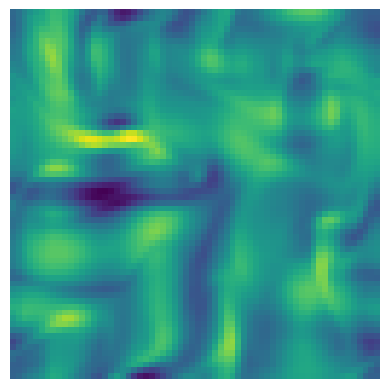

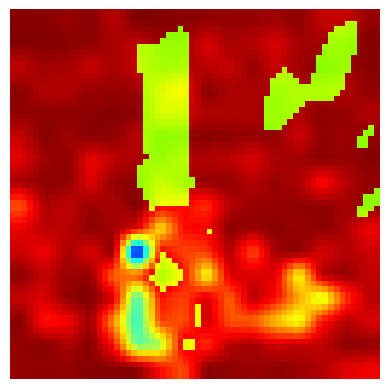

torch.Size([1, 2, 64, 64])
Doing Attention Rollout
here1
here
reg
reg
reg
reg
call
computed o/p
(16, 16)
ytrue  (2, 64, 64)
y_true_original (2, 64, 64)
img   (3, 64, 64)
mas   (64, 64)
img  (3, 64, 64)
hm  (3, 64, 64)
hm  (3, 64, 64)
msk  (3, 64, 64)
img*   (2, 64, 64)
img**   (64, 64, 2)


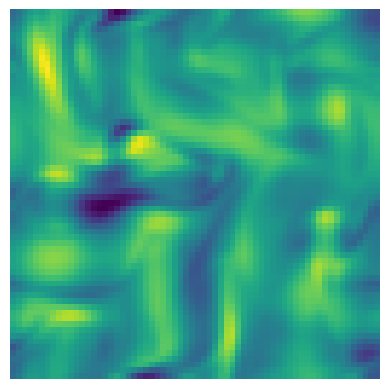

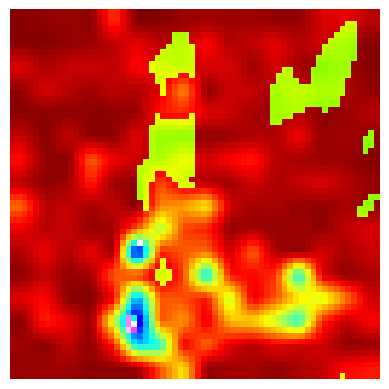

In [31]:
import matplotlib.pyplot as plt

for i in range(2):
    # fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    
    # Save predicted image
    # pred_path = os.path.join(pred_dir, f'predicted_{i}.png')
    # plt.imsave(pred_path, (y_pred[i].cpu().detach().numpy()).squeeze())
    
    # # Save true image
    # true_path = os.path.join(true_dir, f'true_{i}.png')
    # plt.imsave(true_path, (y_true[i].cpu().detach().numpy()).squeeze())
    
    # plt.close(fig)
    # img = Image.open(args.image_path)
    # img = img.resize((224, 224))
    # input_tensor = transform(img).unsqueeze(0)
    # if args.use_cuda:
    #     input_tensor = input_tensor.cuda()
    input_tensor = torch.tensor(y_true[i]).to(device)
    input_tensor = input_tensor.unsqueeze(0)
    # model(input_tensor)
    print(input_tensor.shape)

    # if args.category_index is None:
    print("Doing Attention Rollout")
    head_fusion = 'max'
    discard_ratio = 0.9
    attention_rollout = VITAttentionRollout(model,  head_fusion='max', 
        discard_ratio=0.9)
    img = y_true[i]
    # img = y_true[i].unsqueeze(0)
    mask = attention_rollout(input_tensor)
    print(mask.shape)
    # # name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, args.head_fusion)
    # # else:
    # #     print("Doing Gradient Attention Rollout")
    # #     grad_rollout = VITAttentionGradRollout(model, discard_ratio=args.discard_ratio)
    # #     mask = grad_rollout(input_tensor, args.category_index)
    # #     name = "grad_rollout_{}_{:.3f}_{}.png".format(args.category_index,
    # #         args.discard_ratio, args.head_fusion)

    print("ytrue ", y_true[i].shape)

    np_img = y_true[i][:, :, ::-1]
    y_true_original = np_img.squeeze()
    print("y_true_original", y_true_original.shape)
    np_img = np.concatenate((np_img, np.zeros((1, 64, 64))), axis=0)

    print("img  ", np_img.shape)
    mask = cv2.resize(mask, (np_img.shape[2], np_img.shape[1]))
    print("mas  ", mask.shape)
    mask = show_mask_on_image(np_img, mask)
    print("msk ", mask.shape)

    print("img*  ", y_true_original.shape)
    print("img**  ", (y_true_original.squeeze()).transpose(1,2,0).shape)
    plt.imshow(vorticity((y_true_original.squeeze()).transpose(1,2,0)))
    plt.axis('off')  # Turn off axis
    plt.show()

    plt.imshow(mask.T)
    plt.axis('off')  # Turn off axis
    plt.show()
    # cv2.imshow("Input Image", np_img)
    # cv2.imshow(name, mask)
    # cv2.imwrite("input.png", np_img)
    # cv2.imwrite(name, mask)
    # cv2.waitKey(-1)

In [32]:
import numpy as np

def add_mask_to_image(image_2channel, mask_3channel):
    """
    Add a 3-channel mask onto a 2-channel image.


    Args:
    - image_2channel: NumPy array representing the 2-channel image.
    - mask_3channel: NumPy array representing the 3-channel mask.

    Returns:
    - result_image: NumPy array representing the result of adding the mask onto the image.
    """
    # Ensure both image and mask have the same dimensions
    assert image_2channel.shape[:2] == mask_3channel.shape[:2], "Image and mask dimensions do not match"

    # Create a new array for the result image with 5 channels (2 from the image, 3 from the mask)
    result_image = np.zeros((*image_2channel.shape[:2], 5), dtype=np.uint8)

    # Copy the 2-channel image into the result image
    result_image[..., :2] = image_2channel

    # Blend the 3-channel mask onto the result image
    result_image[..., 2:] = mask_3channel

    return result_image

# Example usage
image_2channel = np.random.randint(0, 256, size=(100, 100, 2), dtype=np.uint8)  # Example 2-channel image
mask_3channel = np.random.randint(0, 256, size=(100, 100, 3), dtype=np.uint8)    # Example 3-channel mask

result_image = add_mask_to_image(image_2channel, mask_3channel)


(5, 100, 100)


TypeError: Invalid shape (2, 100, 100) for image data

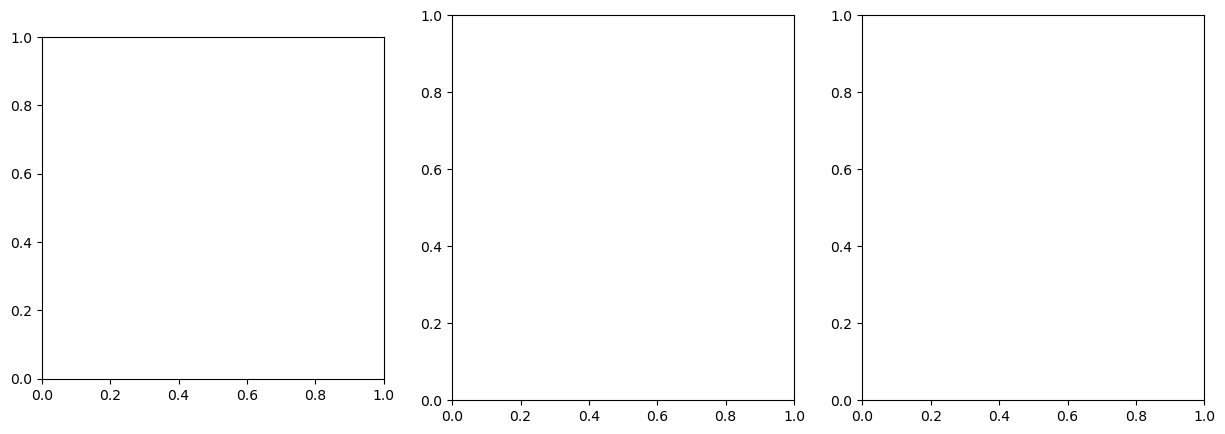

In [33]:
import matplotlib.pyplot as plt

def plot_images(image_2channel, mask_3channel, result_image):
    """
    Plot the original 2-channel image, the 3-channel mask, and the resulting 5-channel image.

    Args:
    - image_2channel: NumPy array representing the 2-channel image.
    - mask_3channel: NumPy array representing the 3-channel mask.
    - result_image: NumPy array representing the result of adding the mask onto the image.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original 2-channel image
    axes[0].imshow(image_2channel)
    axes[0].set_title('2-Channel Image')
    axes[0].axis('off')

    # Plot the 3-channel mask
    axes[1].imshow(mask_3channel)
    axes[1].set_title('3-Channel Mask')
    axes[1].axis('off')

    # Plot the resulting 5-channel image
    axes[2].imshow(result_image)
    axes[2].set_title('Result Image')
    axes[2].axis('off')

    plt.show()

# Example usage
print(result_image.transpose(2, 0, 1).shape)
plot_images(image_2channel.transpose(2, 0, 1), mask_3channel.transpose(2, 0, 1), result_image.transpose(2, 0, 1))
